# **1-4. 스토킹 유형 분류 모델 학습**

---
> 전체 스토킹 잠재/가해 라벨 데이터에 대해 스토킹의 유형을 분류하는 모델을 학습합니다.
> 확실한 라벨이 존재하지 않으며, 유형 간 중첩되는 키워드나 상황이 존재하므로, 각 스토킹 유형에 해당할 **확률**을 예측합니다.
---

In [ ]:
# 드라이브 내 Custom Module 및 .ipynb 파일, 그리고 학습 데이터를 저장한 Directory를 입력하세요.
# 설문조사는 총 11개 문항으로 이루어져 있습니다. 학습을 원하는 문항의 번호를 입력하세요.

DIRECTORY = "AI경진대회" # 여기를 변경하세요.

## **(1) 라이브러리 준비**

In [ ]:
!pip install glove-python-binary
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 15.1 MB/s 
     |████████████████████████████████| 465 kB 45.5 MB/s 


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from konlpy.tag import Okt
from glove import Corpus, Glove

## **(2) Drive Mount 및 Custom Module 불러오기**

In [ ]:
# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

# Directory 변경
path = "/content/gdrive/My Drive/" + DIRECTORY
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
from utils import stalking_cat

## **(3) 데이터셋 불러오기**

In [ ]:
# 데이터셋 준비

data = pd.read_csv('./DATA/Luv.D/경진대회 데이터_수정본.csv')

In [ ]:
# 잠재/가해자 데이터 추출

data = data[(data['warning']==1) | (data['warning']==2)]
data = data.iloc[:, 1:-2].reset_index(drop=True)
data.shape

(78, 11)

## **(4) GloVe 학습을 위한 전처리**

In [ ]:
# 각 데이터에 대해 11개 설문조사 문항의 답변을 하나의 텍스트로 취합

temp = []

for i in tqdm(range(data.shape[0])):
    text = str(data.iloc[i,0])
    for j in list(data.columns)[1:]:
        text = text + ' ' + str(data.loc[i, j])
    temp.append(text)

100%|██████████| 78/78 [00:00<00:00, 4279.12it/s]


In [ ]:
# 한글 빼고 모두 제거

kor = []

for i in tqdm(range(len(temp))):
    text = temp[i]
    edit = re.sub('[^A-Za-z가-힣 ]', '', text)
    kor.append(edit)

100%|██████████| 78/78 [00:00<00:00, 6639.65it/s]


In [ ]:
# Okt를 활용한 명사 수준의 키워드 추출

okt = Okt()
words = []
stopwords = ['사람', '시간', '선물', '여자친구', '남자친구', '여친','남친', '서로', '생각', '동안', '자기', '모습', '마음',
              '하루', '친구들', '하니', '대해', '한번', '데이트', '하자', '친구', '이제', '이해', '상대방', '정도', '지금', 
              '얘기', '이야기', '이상', '먼저', '마지막', '감정', '생일', '시작', '때문', '연애', '상태', '모두', '우리',  
              '그냥', '관계', '대한', '이유', '상황', '무슨', '다른', '조금', '주변', '사이', '편이', '성격', '저희', '무엇', 
              '그날', '사람들', '보고', '처음', '다음', '바로', '다음날', '그때', '이후', '자신', '위해', '방법', '간다', 
              '행동', '배려', '기억', '그게', '하나', '거의', '여행', '약속', '진짜', '사실', '여자', '표현', '그 이후', 
              '정말', ' 가지', '저녁', '입장', '초반', '가지', '혼자', '얼굴', '이번', '가지', '거기', '통해', '본인', 
              '한적', '현재', '다해', '주지', '가라', '그 다음날', '부분', '일들', '그동안', '그거', '확인', '누구', '그것',
              '일이', '모든' ,'만큼', '일도', '존재', '생활', '정신','커플', '요리', '운동', '처럼', '소개', '나중', '나름',
              '오빠', '남자', '해도', '순간', '잠시', '오늘', '는걸', '그 사람', '느낌', '가끔', '부모님', '평소', '사진', 
              '기분', '갑자기', '제', '이', '그', '저', '는', '함', '것', '사람', '해주', '다', '대요', '그간', '내', '라며', 
              '혹', '터넷', '인지', '때', '연락', '심', '앞', '둘', '전', '월', '때', '더', '한번', '지금', '때문', '등', '거',
              '도', '날', '대','내', '나', '준영', '페러글라이딩', '화가', '너', '또', '걸', '번', '못', '안', '수', '게', '의',
              '과', '를', '만', '대하', '다날', '속', '렸', '반', '회', '및', '구나', '거기', '네', '줄', '식', '니야', '이안', 
              '머', '뎅', '읺', '덩', '끔', '더리', '후']

for i in tqdm(range(len(kor))):
    text = kor[i]
    lemmatized = okt.nouns(text)
    tt = []
    for j in lemmatized:
        if j not in stopwords:
            tt.append(j)
        else:
            pass
    words.append(tt)

100%|██████████| 78/78 [00:27<00:00,  2.82it/s]


## **(5) GloVe 학습**

In [ ]:
# Corpus 구성

corpus = Corpus()
corpus.fit(words, window=50)

In [ ]:
# GloVe

glove = Glove(no_components=100, learning_rate=0.01)
%time glove.fit(corpus.matrix, epochs=20)
glove.add_dictionary(corpus.dictionary)

CPU times: user 22.1 s, sys: 34.2 ms, total: 22.1 s
Wall time: 11.4 s


In [ ]:
# word dict 생성

word_dict = {}
for word in  glove.dictionary.keys():
    word_dict[word] = glove.word_vectors[glove.dictionary[word]]
print('Word Dictionary 크기 : ', len(word_dict))

Word Dictionary 크기 :  3350


## **(6) 데이터별 스토킹 유형 분포 확인**

In [ ]:
# 13가지 유형별 확률 데이터프레임

new = {'찾아가기': [],
       '접근하기': [],
       '기다리기': [],
       '미행하기': [], 
       '지켜보기': [], 
       '연락 도달하게 하기': [], 
       '두드리기': [], 
       '물건 놓아두기': [], 
       '진로방해': [], 
       '배회하기': [], 
       '지인에게 연락': [], 
       '침입': [], 
       '기타': []}

for j in tqdm(range(data.shape[0])):
    probs = stalking_cat(glove=glove,
                         number=20, 
                         last=data['last'][j],
                         reason=data['reason'][j],
                         action=data['action'][j],
                         try_=data['try'][j],
                         reaction=data['reaction'][j],
                         valuable=data['valuable'][j],
                         start=data['start'][j],
                         charmingLover=data['charmingLover'][j],
                         charmingCustomer=data['charmingCustomer'][j],
                         relation=data['relation'][j],
                         event=data['EVENT'][j])
    for k in range(len(list(new.keys()))):
        new[list(new.keys())[k]].append(probs[k])
        
new = pd.DataFrame(new)
new.head()

100%|██████████| 78/78 [00:03<00:00, 24.39it/s]


,찾아가기,접근하기,기다리기,미행하기,지켜보기,연락 도달하게 하기,두드리기,물건 놓아두기,진로방해,배회하기,지인에게 연락,침입,기타
0,0.004813,0.000000,0.014775,0.063904,0.013188,0.621471,0.002372,0.002391,0.009041,0.255731,0.009608,0.002704,0.000000
1,0.000000,0.000000,0.000000,0.129678,0.000000,0.440475,0.044007,0.000000,0.047235,0.292281,0.046325,0.000000,0.000000
2,0.003042,0.002567,0.003487,0.036537,0.005154,0.668473,0.017880,0.000000,0.008169,0.237559,0.009073,0.002789,0.005270
3,0.008917,0.000000,0.010950,0.026213,0.009770,0.623017,0.000000,0.020557,0.015972,0.248386,0.018391,0.008648,0.009178
4,0.000000,0.000000,0.007261,0.071961,0.006848,0.609052,0.006695,0.000000,0.022964,0.275219,0.000000,0.000000,0.000000


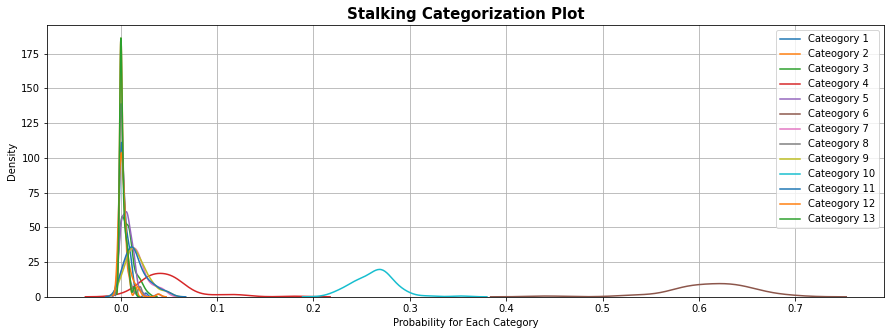

In [ ]:
# 모델 학습 결과

f, ax = plt.subplots(figsize=(15, 5))
plt.title("Stalking Categorization Plot", fontsize=15, weight='bold')
plt.xlabel('Probability for Each Category')
sns.kdeplot(new['찾아가기'], label='Cateogory 1')
sns.kdeplot(new['접근하기'], label='Cateogory 2')
sns.kdeplot(new['기다리기'], label='Cateogory 3')
sns.kdeplot(new['미행하기'], label='Cateogory 4')
sns.kdeplot(new['지켜보기'], label='Cateogory 5')
sns.kdeplot(new['연락 도달하게 하기'], label='Cateogory 6')
sns.kdeplot(new['두드리기'], label='Cateogory 7')
sns.kdeplot(new['물건 놓아두기'], label='Cateogory 8')
sns.kdeplot(new['진로방해'], label='Cateogory 9')
sns.kdeplot(new['배회하기'], label='Cateogory 10')
sns.kdeplot(new['지인에게 연락'], label='Cateogory 11')
sns.kdeplot(new['침입'], label='Cateogory 12')
sns.kdeplot(new['기타'], label='Cateogory 13')

plt.legend()
plt.grid(True)

## **(7) GloVe 모델 저장**

In [ ]:
glove.save('./NEW_MODEL/GloVe/glove_category.model')